# The following script is designed to walk through the process of finding the lowest energy conformers for molecules using RDKit's force field method

We'll start by performing step by step analysis on a single molecule, then perform this analysis on a list of molecules, and finally develop a function to do this automatically

In [1]:
import os
import sys
import logging
FORMAT = "%(filename)s:%(lineno)d %(funcName)s %(levelname)s %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

import re
import imp
import itertools
import random
import numpy as np
from numpy import array
import pandas as pd
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns


# do this before we have a chance to import openbabel!
import rdkit, rdkit.Chem.rdDistGeom, rdkit.DistanceGeometry

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit import rdBase
from rdkit.Chem.rdMolTransforms import *

import py3Dmol

from rmgpy.molecule import Molecule
from rmgpy.species import Species
from rmgpy.reaction import Reaction
from rmgpy.kinetics import PDepArrhenius, PDepKineticsModel

from rmgpy.data.rmg import RMGDatabase
from rmgpy.data.kinetics import KineticsDepository, KineticsRules
from rmgpy.qm.main import QMCalculator, QMSettings
from rmgpy.qm.qmdata import QMData
from rmgpy.qm.reaction import QMReaction
from rmgpy.qm.molecule import QMMolecule


/Users/nathan/anaconda/envs/rmg_env/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def view_mol(mol):
    """
    A function designed to visulaize rdkit molecules
    
    Input: 
    * mol (an rdkit molecule object)
    
    Output: 
    * 3D figure of the molecule from py3Dmol
    
    """
    mb  = Chem.MolToMolBlock(mol)
    p = py3Dmol.view(width=400, height=400)
    p.addModel(mb, "sdf")
    p.setStyle({'stick':{}})
    p.setBackgroundColor('0xeeeeee')
    p.zoomTo()
    return p.show()
    
    

In [3]:
def calc_energy(mol):
    """
    A function designed to calculate the energy of a molecule or TS.
    
    Input: 
    * rdkit molecule object
    
    Output: 
    * energy of the geometry calculated using rdkit's forcefield method
    * the resultant rdkit molecule object
    """
    # Setting the force field parameters
    try:
        molprop = rdkit.Chem.ChemicalForceFields.MMFFGetMoleculeProperties(mol)
    except:
        # Picking an arbitrarly large molecule to create a dummy mol properties forcefield object
        # This is primarily used for TSs
        test_mol = Chem.AddHs(Chem.MolFromSmiles(
            "COC(=O)Cc1ccccc1CC2CC(O)C(C(=C)CC#CCC=O)C2OO"
        ))
        molprop = rdkit.Chem.ChemicalForceFields.MMFFGetMoleculeProperties(test_mol)
        
    ff = rdkit.Chem.ChemicalForceFields.MMFFGetMoleculeForceField(mol, molprop)
    
    
    
    return ff.CalcEnergy(), mol

In [40]:
def constrained_energy_calc(mol, list_of_torsions, angles):
    """
    A function designed to calculate the energy of a molecule or TS.
    For this function, the molecule torsions are fixed, 
    but the rest of the molecule is allowed to relax to a local minimum
    
    Input: 
    * rdkit molecule object
    * list of torsions as (i,j,k,l) tuples
    * list of angles to set the corresponding torsions to
    
    Output: 
    * energy of the geometry calculated using rdkit's forcefield method
    * the resultant rdkit molecule object
    """
    e, m = calc_energy(mol)
    # Setting the force field parameters
    try:
        molprop = rdkit.Chem.ChemicalForceFields.MMFFGetMoleculeProperties(mol)
    except:
    
        # Picking an arbitrarly large molecule to create a dummy mol properties forcefield object
        # This is primarily used for TSs
        test_mol = Chem.AddHs(Chem.MolFromSmiles(
            "COC(=O)Cc1ccccc1CC2CC(O)C(C(=C)CC#CCC=O)C2OO"
        ))
        molprop = rdkit.Chem.ChemicalForceFields.MMFFGetMoleculeProperties(test_mol)
    ff = rdkit.Chem.ChemicalForceFields.MMFFGetMoleculeForceField(mol, molprop)
    
    # Zipping the torsion list and the angles together
    geometries = zip(list_of_torsions, angles)
    
    # Generating a conformer to edit
    tup = mol.GetConformers()
    conformer = tup[0]
    
    # Setting the corresponding torsion to their proper angles
    for geometry in geometries:
        
        i = geometry[0][0]
        j = geometry[0][1]
        k = geometry[0][2]
        l = geometry[0][3]
        angle = geometry[1]
        
        SetDihedralDeg(conformer,
                           i, 
                           j, 
                           k, 
                           l,
                           angle)
        
        # Constraining the torsions of the molecule
        ff.MMFFAddTorsionConstraint(i,j,k,l, True, angle, angle, 1)
     

    e, m = calc_energy(mol)
    # Optimizing the molecule
    AllChem.MMFFOptimizeMolecule(mol)
    
    
    
    return ff.CalcEnergy(), mol, e






In [5]:
def optimize_and_calc(mol, list_of_torsions, angles):
    """
    A function designed to calculate the energy of a molecule or TS.
    For this function, the torsions of the molecule are set to their corresponding angles,
    then the molecule is allowed to relax to a local minimum
    
    Input: 
    * rdkit molecule object
    * list of torsions as (i,j,k,l) tuples
    * list of angles to set the corresponding torsions to
    
    Output: 
    * energy of the geometry calculated using rdkit's forcefield method
    * the resultant rdkit molecule object
    """
    
    # Setting the force field parameters
    try:
        molprop = rdkit.Chem.ChemicalForceFields.MMFFGetMoleculeProperties(mol)
    except:
        # Picking an arbitrarly large molecule to create a dummy mol properties forcefield object
        # This is primarily used for TSs
        test_mol = Chem.AddHs(Chem.MolFromSmiles(
            "COC(=O)Cc1ccccc1CC2CC(O)C(C(=C)CC#CCC=O)C2OO"
        ))
        
        molprop = rdkit.Chem.ChemicalForceFields.MMFFGetMoleculeProperties(test_mol) 
    ff = rdkit.Chem.ChemicalForceFields.MMFFGetMoleculeForceField(mol, molprop)
    
    # Zipping the torsions and their corresponding angles together
    geometries = zip(list_of_torsions, angles)
    
    # Generating conformers and selecting one
    tup = mol.GetConformers()
    conformer = tup[0]
    
    for geometry in geometries:
        # Setting the torsion angles
        i = geometry[0][0]
        j = geometry[0][1]
        k = geometry[0][2]
        l = geometry[0][3]
        angle = geometry[1]
        
        SetDihedralDeg(conformer,
                           i, 
                           j, 
                           k, 
                           l,
                           angle)
    
    # Allowing the molecule to relax
    AllChem.MMFFOptimizeMolecule(mol)
    
    
    return ff.CalcEnergy(), mol

# This portion is for optimization of reactants and products 

In [6]:
test_mol = Chem.AddHs(Chem.MolFromSmiles(
    "COC(=O)Cc1ccccc1CC2CC(O)C(C(=C)CC#CCC=O)C2OO"
))

AllChem.EmbedMolecule(test_mol)

view_mol(test_mol)

# Example with one single rotor

For this we will be looking at methoxyethane. We chose this molecule because it has three local minima for it's one torsion. For now we will just test the above functions using this molecule

In [7]:
RDMol = Chem.AddHs(Chem.MolFromSmiles(
            "CCOC"
        ))
rdkit.Chem.AllChem.EmbedMolecule(RDMol)

view_mol(RDMol)

In [8]:
print rdkit.Chem.MolToMolBlock(RDMol)
tsRDMol = rdkit.Chem.rdchem.RWMol(RDMol)

e, m = calc_energy(RDMol)
print e
view_mol(m)


     RDKit          3D

 12 11  0  0  0  0  0  0  0  0999 V2000
    1.6100    0.2882    0.4107 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.4508   -0.5503   -0.0674 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.4221    0.1812   -0.8505 O   0  0  0  0  0  0  0  0  0  0  0  0
   -1.7131    0.2377   -0.3513 C   0  0  0  0  0  0  0  0  0  0  0  0
    2.2927    0.5949   -0.3952 H   0  0  0  0  0  0  0  0  0  0  0  0
    1.1615    1.1831    0.9112 H   0  0  0  0  0  0  0  0  0  0  0  0
    2.1471   -0.3225    1.1734 H   0  0  0  0  0  0  0  0  0  0  0  0
    0.8659   -1.4315   -0.5906 H   0  0  0  0  0  0  0  0  0  0  0  0
   -0.0804   -0.8810    0.8604 H   0  0  0  0  0  0  0  0  0  0  0  0
   -2.3688   -0.2692   -1.0777 H   0  0  0  0  0  0  0  0  0  0  0  0
   -2.1065    1.2623   -0.2398 H   0  0  0  0  0  0  0  0  0  0  0  0
   -1.8370   -0.2930    0.6146 H   0  0  0  0  0  0  0  0  0  0  0  0
  1  2  1  0
  2  3  1  0
  3  4  1  0
  1  5  1  0
  1  6  1  0
  1  7  1  0
  2  8  1  0
  2 

## This next portion will perform a conformer analysis

We'll start by recreating the molecule again

In [41]:
RDMol = Chem.AddHs(Chem.MolFromSmiles(
            "CCOC"
        ))
rdkit.Chem.AllChem.EmbedMolecule(RDMol)

view_mol(RDMol)

In [42]:
print rdkit.Chem.MolToMolBlock(RDMol)
RDMol = rdkit.Chem.rdchem.RWMol(RDMol)

e, m = calc_energy(RDMol)
print e
view_mol(m)


     RDKit          3D

 12 11  0  0  0  0  0  0  0  0999 V2000
   -1.4436    0.4056    0.0658 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.4642   -0.6606   -0.3646 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.5822   -0.7229    0.5217 O   0  0  0  0  0  0  0  0  0  0  0  0
    1.6306    0.1301    0.2628 C   0  0  0  0  0  0  0  0  0  0  0  0
   -2.2628    0.5301   -0.6806 H   0  0  0  0  0  0  0  0  0  0  0  0
   -1.8422    0.0915    1.0642 H   0  0  0  0  0  0  0  0  0  0  0  0
   -0.8930    1.3749    0.1629 H   0  0  0  0  0  0  0  0  0  0  0  0
   -0.1627   -0.5720   -1.4283 H   0  0  0  0  0  0  0  0  0  0  0  0
   -1.0362   -1.6226   -0.3128 H   0  0  0  0  0  0  0  0  0  0  0  0
    1.7270    0.4405   -0.7933 H   0  0  0  0  0  0  0  0  0  0  0  0
    2.5630   -0.4119    0.5652 H   0  0  0  0  0  0  0  0  0  0  0  0
    1.6020    1.0174    0.9370 H   0  0  0  0  0  0  0  0  0  0  0  0
  1  2  1  0
  2  3  1  0
  3  4  1  0
  1  5  1  0
  1  6  1  0
  1  7  1  0
  2  8  1  0
  2 

### Now we're going to find the indicies of the atoms participating in the torsion

In [43]:

torsion_list = []

for bond1 in RDMol.GetBonds():
    
    atom1 = bond1.GetBeginAtom()
    atom2 = bond1.GetEndAtom()
    if atom1.IsInRing() or atom2.IsInRing() or atom1.GetAtomicNum() == 1 or atom2.GetAtomicNum() == 1:
        # Making sure that the atoms we're looking at are
        # not hydrogen or in a ring
        continue
    
    bond_list1 = list(atom1.GetBonds())
    bond_list2 = list(atom2.GetBonds())

    if not len(bond_list1) > 1 and not len(bond_list2) > 1:
        # Making sure that there are more than one bond attached to
        # the atoms we're looking at
        continue
        

    # Getting the 0th and 3rd atom and encuring that atoms 
    # attached to the 1st and 2nd atom are not all hydrogens
    # If not, we append a tuple of the torsion our torsion_list
    atom_count0 = 0
    hydrogen_count0 = 0
    
    for bond0 in bond_list1:
        atomX = bond0.GetOtherAtom(atom1)
        if atomX.GetIdx() != atom2.GetIdx():
            atom0 = atomX
            atom_count0 += 1
        if atomX.GetAtomicNum() == 1:
            hydrogen_count0 += 1
            
    atom_count1 = 0
    hydrogen_count1 = 0
            
    for bond2 in bond_list2:
        atomY = bond2.GetOtherAtom(atom2)
        if atomY.GetIdx() != atom1.GetIdx():
            atom3 = atomY
            atom_count1 += 1
        if atomY.GetAtomicNum() == 1:
            hydrogen_count1 += 1
            
    if atom_count0 != hydrogen_count0 and atom_count1 != hydrogen_count1:
        torsion_tup = (atom0.GetIdx(), atom1.GetIdx(), atom2.GetIdx(), atom3.GetIdx())
        torsion_list.append(torsion_tup)
    
torsion_list

[(8, 1, 2, 3)]

In [44]:
e, mol = constrained_energy_calc(RDMol, torsion_list, [90])
print e
view_mol(mol)


ValueError: too many values to unpack

In [45]:
e, mol = optimize_and_calc(RDMol, torsion_list, [90])
print e
view_mol(mol)


3.8783308316


### Now we will loop through torsion angles ranging between 0 degrees to 360 degrees using increments of 10 degrees. We will calculate the enegy at each step and create a list of lists containing the energy and the torsion angle

In [46]:
torsion_angles = np.arange(0, 360+10,10)
torsion_combos = list( itertools.combinations_with_replacement( torsion_angles, len(torsion_list)) )
#torsion_combos = torsion_combos + list(itertools.combinations_with_replacement( torsion_angles[::-1], len(torsion_list)) )

df = []


torsion_combos
tup = RDMol.GetConformers()
conformer = tup[0]
for combo in torsion_combos:
    

    geometry = zip(torsion_list, combo)
    
    for torsion in geometry:
        i = torsion[0][0]
        j = torsion[0][1]
        k = torsion[0][2]
        l = torsion[0][3]
        angle = torsion[1]
        
        SetDihedralDeg(conformer,
                       i, 
                       j, 
                       k, 
                       l,
                       angle)
    e0, m0 = calc_energy(RDMol)
    e1, m1, ee = constrained_energy_calc(RDMol, torsion_list, combo)
    e2, m2 = optimize_and_calc(RDMol, torsion_list, combo)
    
    df.append( [e0, 
                ee,
                e1,
                e2] 
              + list(combo))
    


In [47]:
i, j , k, l

(8, 1, 2, 3)

In [48]:
df = pd.DataFrame(df)
columns = ["No Optimization","Pre-Partial Optimization", "Partial Optimization", "Full Optimization"]
for i in range(len(torsion_list)):
    columns.append("Tor " + str(i))

df.columns = columns

df.sort("No Optimization")

/Users/nathan/anaconda/envs/rmg_env/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,No Optimization,Pre-Partial Optimization,Partial Optimization,Full Optimization,Tor 0
6,3.878333,3.878333,4.427210,3.878331,60
5,4.079445,4.079445,4.122401,3.878331,50
7,4.081887,4.081887,4.853866,3.878331,70
4,4.626494,4.626494,3.939443,3.878331,40
8,4.630684,4.630684,5.402368,3.878331,80
3,5.362502,5.362502,3.878331,3.878331,30
9,5.367252,5.367252,6.072717,3.878331,90
16,5.395926,5.395926,9.147643,5.376945,160
31,5.419967,5.419967,5.818843,5.376945,310
32,5.473261,5.473261,5.551601,5.376945,320


### Finally we visualize the data

Also, our findings for this conformer analysis are similar to that of `http://onlinelibrary.wiley.com/doi/10.1002/jcc.10271/full`

/Users/nathan/anaconda/envs/rmg_env/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


(0, 25)

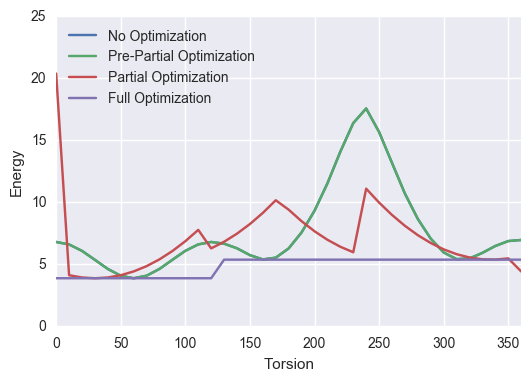

In [49]:
plot = df.sort("Tor 0").plot("Tor 0")
plot.set_ylabel("Energy")
plot.set_xlabel("Torsion")
plot.set_ylim([0,25])


# This next portion is designed to do the above but for a variety of molecules

For this we are looking at a series of 5 molecules with a variety geometries

In [ ]:
list_of_smiles = [
    'CCCC',
    'CCC#CC',
    'CCC=CCC',
    'CCOC',
    "CCCC1(CCC)OCC(C)C1"
]

for smiles in list_of_smiles:
    RDMol = Chem.AddHs(Chem.MolFromSmiles(
            smiles
        ))
    rdkit.Chem.AllChem.EmbedMolecule(RDMol)

    #print view_mol(RDMol)

    
    print rdkit.Chem.MolToMolBlock(RDMol)
    print
    RDMol = rdkit.Chem.rdchem.RWMol(RDMol)
    torsion_list = []

    for bond1 in RDMol.GetBonds():

        atom1 = bond1.GetBeginAtom()
        atom2 = bond1.GetEndAtom()
        if atom1.IsInRing() or atom2.IsInRing() or atom1.GetAtomicNum() == 1 or atom2.GetAtomicNum() == 1:
            # Making sure that the atoms we're looking at are
            # not hydrogen or in a ring
            continue

        bond_list1 = list(atom1.GetBonds())
        bond_list2 = list(atom2.GetBonds())

        if not len(bond_list1) > 1 and not len(bond_list2) > 1:
            # Making sure that there are more than one bond attached to
            # the atoms we're looking at
            continue


        # Getting the 0th and 3rd atom and encuring that atoms 
        # attached to the 1st and 2nd atom are not all hydrogens
        # If not, we append a tuple of the torsion our torsion_list
        atom_count0 = 0
        hydrogen_count0 = 0

        for bond0 in bond_list1:
            atomX = bond0.GetOtherAtom(atom1)
            if atomX.GetIdx() != atom2.GetIdx():
                atom0 = atomX
                atom_count0 += 1
            if atomX.GetAtomicNum() == 1:
                hydrogen_count0 += 1

        atom_count1 = 0
        hydrogen_count1 = 0

        for bond2 in bond_list2:
            atomY = bond2.GetOtherAtom(atom2)
            if atomY.GetIdx() != atom1.GetIdx():
                atom3 = atomY
                atom_count1 += 1
            if atomY.GetAtomicNum() == 1:
                hydrogen_count1 += 1

        if atom_count0 != hydrogen_count0 and atom_count1 != hydrogen_count1:
            torsion_tup = (atom0.GetIdx(), atom1.GetIdx(), atom2.GetIdx(), atom3.GetIdx())
            torsion_list.append(torsion_tup)
    print torsion_list
        
        
        

    torsion_angles = np.arange(0, 360+30,30)
    torsion_combos = list( itertools.combinations_with_replacement( torsion_angles, len(torsion_list)) )
    torsion_combos = torsion_combos + list(itertools.combinations_with_replacement( torsion_angles[::-1], len(torsion_list)) )

    df = []

    
    tup = RDMol.GetConformers()
    conformer = tup[0]
    for combo in torsion_combos:


        geometry = zip(torsion_list, combo)

        for torsion in geometry:
            i = torsion[0][0]
            j = torsion[0][1]
            k = torsion[0][2]
            l = torsion[0][3]
            angle = torsion[1]

            SetDihedralDeg(conformer,
                           i, 
                           j, 
                           k, 
                           l,
                           angle)
        
        e0, m0 = calc_energy(RDMol)
        e1, m1 = constrained_energy_calc(RDMol, torsion_list, combo)
        e2, m2 = optimize_and_calc(RDMol, torsion_list, combo)

        df.append( [e0, e1, e2,
                   m0, m1, m2] 
                  + list(combo))
        

    df = pd.DataFrame(df)
    columns = ["No Optimization Energy", "Partial Optimization Energy", "Full Optimization Energy",
              "No Optimization Mol", "Partial Optimization Mol", "Full Optimization Mol"]
    for i in range(len(torsion_list)):
        columns.append("Tor " + str(i))

    df.columns = columns

    print df.sort("Tor 0").iloc[0]
    print df.sort("Tor 0").iloc[0]["No Optimization Mol"]
    print
    
    print rdkit.Chem.MolToMolBlock(RDMol)
    print
    print

## The following functions should be what you need to get the lowest energy conformer

Moving forward one should just need to use the following function to get the minimum energy by force field optimization via RDkit


#### There are some issues with the following portion of the code... This might be because I changed some of the above functions around.

In [ ]:

def get_lowest_energy_conformer(smiles):
    RDMol = Chem.AddHs(Chem.MolFromSmiles(
            smiles
        ))
    rdkit.Chem.AllChem.EmbedMolecule(RDMol)

    view_mol(RDMol)
    
    RDMol = rdkit.Chem.rdchem.RWMol(RDMol)
    
    torsion_list = []
    for bond1 in RDMol.GetBonds():
        atom1 = bond1.GetBeginAtom()
        atom2 = bond1.GetEndAtom()
        if atom1.IsInRing() or atom2.IsInRing() or atom1.GetAtomicNum() == 1 or atom2.GetAtomicNum() == 1:
            # Making sure that the atoms we're looking at are
            # not hydrogen or in a ring
            continue

        bond_list1 = list(atom1.GetBonds())
        bond_list2 = list(atom2.GetBonds())

        if not len(bond_list1) > 1 and not len(bond_list2) > 1:
            # Making sure that there are more than one bond attached to
            # the atoms we're looking at
            continue


        # Getting the 0th and 3rd atom and encuring that atoms 
        # attached to the 1st and 2nd atom are not all hydrogens
        # If not, we append a tuple of the torsion our torsion_list
        atom_count0 = 0
        hydrogen_count0 = 0

        for bond0 in bond_list1:
            atomX = bond0.GetOtherAtom(atom1)
            if atomX.GetIdx() != atom2.GetIdx():
                atom0 = atomX
                atom_count0 += 1
            if atomX.GetAtomicNum() == 1:
                hydrogen_count0 += 1

        atom_count1 = 0
        hydrogen_count1 = 0

        for bond2 in bond_list2:
            atomY = bond2.GetOtherAtom(atom2)
            if atomY.GetIdx() != atom1.GetIdx():
                atom3 = atomY
                atom_count1 += 1
            if atomY.GetAtomicNum() == 1:
                hydrogen_count1 += 1

        if atom_count0 != hydrogen_count0 and atom_count1 != hydrogen_count1:
            torsion_tup = (atom0.GetIdx(), atom1.GetIdx(), atom2.GetIdx(), atom3.GetIdx())
            torsion_list.append(torsion_tup)

    torsion_angles = np.arange(0, 360+30,30)
    torsion_combos = list( itertools.combinations_with_replacement( torsion_angles, len(torsion_list)) )
    torsion_combos = torsion_combos + list(itertools.combinations_with_replacement( torsion_angles[::-1], len(torsion_list)) )

    df = []

    tup = RDMol.GetConformers()
    conformer = tup[0]
    for combo in torsion_combos:


        geometry = zip(torsion_list, combo)

        for torsion in geometry:
            i = torsion[0][0]
            j = torsion[0][1]
            k = torsion[0][2]
            l = torsion[0][3]
            angle = torsion[1]

            SetDihedralDeg(conformer,
                           i, 
                           j, 
                           k, 
                           l,
                           angle)
        
        e0, m0 = calc_energy(RDMol)
        e1, m1 = constrained_energy_calc(RDMol, torsion_list, combo)
        e2, m2 = optimize_and_calc(RDMol, torsion_list, combo)

        df.append( [e0, e1, e2,
                   m0, m1, m2] 
                  + list(combo))
        
        
    df = pd.DataFrame(df)
    columns = ["No Optimization Energy", "Partial Optimization Energy", "Full Optimization Energy",
              "No Optimization Mol", "Partial Optimization Mol", "Full Optimization Mol"]
    for i in range(len(torsion_list)):
        columns.append("Tor " + str(i))

    df.columns = columns
    
    lowest_E_mol = df.sort("No Optimization Energy").iloc[0]["No Optimization Mol"]
    print rdkit.Chem.MolToMolBlock(lowest_E_mol)

    #rdkit.Chem.AddHs(lowest_E_mol)
    #rdkit.Chem.AllChem.UFFOptimizeMolecule(lowest_E_mol)
    
    #rdkit.Chem.AllChem.EmbedMolecule(lowest_E_mol)
    return lowest_E_mol
    
    

In [ ]:

lowest_E = get_lowest_energy_conformer("CCOCC(=O)OCC")
#lowest_E = get_lowest_energy_conformer("COC(=O)Cc1ccccc1CC2CC(O)C(C(=C)CC#CCC=O)C2OO")
view_mol(lowest_E)

In [ ]:

lowest_E = get_lowest_energy_conformer("CC(C)(C)OCC(CO)OC(C)(C)C")
#lowest_E = get_lowest_energy_conformer("COC(=O)Cc1ccccc1CC2CC(O)C(C(=C)CC#CCC=O)C2OO")
view_mol(lowest_E)

In [ ]:
get_lowest_energy_conformer("CCCC")